In [3]:
import torch
import torch.nn as nn
# from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import time

In [2]:
# history -g

In [14]:
if torch.cuda.is_available():
    print("CUDA runningdddd")
    dtype = torch.cuda.FloatTensor
else:
    if torch.cuda.is_available():
        print("CUDA available, could have run with --cuda")
    dtype = torch.FloatTensor

In [5]:
L = 1 # FIXED length of domain

In [5]:
class UNetv2(nn.Module):
    def __init__(
        self, 
        dtype, 
        img_size = 32, # pre-defined domain_size settings
        filters = 64, # number of filters
    ):
        super().__init__()
        self.image_size = img_size
        self.layers = int(np.log2(img_size)) # number of layers
        self.filters = filters
        self.dtype = dtype
        kernel_size_list = [4,4,4]
        for k in range(self.layers-3):
            if k % 2 == 0:
                kernel_size_list.insert(k, 3)
            if k % 2 == 1:
                kernel_size_list.insert(k, 4)
        self.encoding_layers = nn.ModuleList()
        self.encoding_BN = nn.ModuleList()
        for i in range(self.layers):
            if i == 0:
                self.encoding_layers.append(nn.Conv2d(1, filters, kernel_size=kernel_size_list[0], stride=2, padding=1))
            else:
                self.encoding_layers.append(nn.Conv2d(min(2**(i-1),8)*filters, min(2**i, 8)*filters, kernel_size=kernel_size_list[i], stride=2, padding=1))
            self.encoding_BN.append(nn.BatchNorm2d(min(2**i*filters, 8*filters)))

        self.encoded = None
    
        self.decoding_layers = nn.ModuleList()
        self.decoding_BN = nn.ModuleList()

        for i in range(self.layers)[::-1]:
            if i == self.layers-1:
                self.decoding_layers.append(nn.ConvTranspose2d(min(2**i*filters, 8*filters), min(2**(i-1)*filters, 8*filters), kernel_size=4, stride=2, padding=1))
            elif i == 0:
                self.decoding_layers.append(nn.ConvTranspose2d(filters*2, 1, kernel_size=4, stride=2, padding=1))
            else:
                self.decoding_layers.append(nn.ConvTranspose2d(min(2**i*filters,8*filters)*2, min(2**(i-1)*filters, 8*filters), kernel_size=4, stride=2, padding=1))
            self.decoding_BN.append(nn.BatchNorm2d(min(max(2**(i-1),1)*filters, 8*filters)))

        self.bd = torch.zeros(1,1,img_size,img_size)
        self.bd[:,:,:,0] = 1
        self.bd[:,:,0,:] = 1
        self.bd[:,:,:,-1] = 1
        self.bd[:,:,-1,:] = 1
    
        self.bd = self.bd.type(dtype)

    def forward(self, x, isNeum=[False, False, False, False]):
        ini_state = x
        x_copy = []
        for i in range(self.layers):
            if i == 0:
                x = F.leaky_relu(self.encoding_layers[i](x), 0.2)
            elif i == self.layers - 1:
                x = self.encoding_layers[i](x)
            else:
                x = F.leaky_relu(self.encoding_BN[i](self.encoding_layers[i](x)), 0.2)
            x_copy.append(x)
        self.encoded = x_copy.pop(-1)
        
        for i in range(self.layers):
            if i == 0:
                x = self.decoding_BN[i](self.decoding_layers[i](F.relu(x)))
            elif i == self.layers - 1:
                x = torch.tanh(self.decoding_layers[i](F.relu(torch.cat((x,x_copy[0]), dim=1))))
            else:
                x = self.decoding_BN[i](self.decoding_layers[i](F.relu(torch.cat((x,x_copy[-1*i]), dim=1))))
        nmbc = 0 * x
        nmbc[:,:,:,0:2] = 1
        nmbc[:,:,0:2,:] = 1
        nmbc[:,:,:,-2:] = 1
        nmbc[:,:,-2:,:] = 1
        if isNeum[0]:
            nmbc[:,:,2:-2,1] = 0
            
        T_results = (x + 1) * 1/2  # x belongs to [-1,1], then (x + 1)* 1/2 *100scaled to 0 ~ 100
        fixed_values = nmbc
        return T_results * (1 - fixed_values) + ini_state * fixed_values
#         return T_results * (1 - self.bd) + ini_state * self.bd

In [6]:
class UNet(nn.Module):
    def __init__(
        self, 
        dtype, 
        img_size = 32, # pre-defined domain_size settings
        filters = 64, # number of filters
    ):
        super().__init__()
        self.image_size = img_size
        self.layers = int(np.log2(img_size)) # number of layers
        self.filters = filters
        self.dtype = dtype

        self.encoding_layers = nn.ModuleList()
        self.encoding_BN = nn.ModuleList()
        for i in range(self.layers):
            if i == 0:
                self.encoding_layers.append(nn.Conv2d(1, filters, kernel_size=4, stride=2, padding=1))
            else:
                self.encoding_layers.append(nn.Conv2d(min(2**(i-1),8)*filters, min(2**i, 8)*filters, kernel_size=4, stride=2, padding=1))
            self.encoding_BN.append(nn.BatchNorm2d(min(2**i*filters, 8*filters)))

        self.encoded = None
    
        self.decoding_layers = nn.ModuleList()
        self.decoding_BN = nn.ModuleList()

        for i in range(self.layers)[::-1]:
            if i == self.layers-1:
                self.decoding_layers.append(nn.ConvTranspose2d(min(2**i*filters, 8*filters), min(2**(i-1)*filters, 8*filters), kernel_size=4, stride=2, padding=1))
            elif i == 0:
                self.decoding_layers.append(nn.ConvTranspose2d(filters*2, 1, kernel_size=4, stride=2, padding=1))
            else:
                self.decoding_layers.append(nn.ConvTranspose2d(min(2**i*filters,8*filters)*2, min(2**(i-1)*filters, 8*filters), kernel_size=4, stride=2, padding=1))
            self.decoding_BN.append(nn.BatchNorm2d(min(max(2**(i-1),1)*filters, 8*filters)))

        self.bd = torch.zeros(1,1,img_size,img_size)
        self.bd[:,:,:,0] = 1
        self.bd[:,:,0,:] = 1
        self.bd[:,:,:,-1] = 1
        self.bd[:,:,-1,:] = 1
    
        self.bd = self.bd.type(dtype)

    def forward(self, x, isNeum=[False, False, False, False]):
        ini_state = x
        x_copy = []
        for i in range(self.layers):
            if i == 0:
                x = F.leaky_relu(self.encoding_layers[i](x), 0.2)
            elif i == self.layers - 1:
                x = self.encoding_layers[i](x)
            else:
                x = F.leaky_relu(self.encoding_BN[i](self.encoding_layers[i](x)), 0.2)
            x_copy.append(x)
        self.encoded = x_copy.pop(-1)
        
        for i in range(self.layers):
            if i == 0:
                x = self.decoding_BN[i](self.decoding_layers[i](F.relu(x)))
            elif i == self.layers - 1:
                x = torch.tanh(self.decoding_layers[i](F.relu(torch.cat((x,x_copy[0]), dim=1))))
            else:
                x = self.decoding_BN[i](self.decoding_layers[i](F.relu(torch.cat((x,x_copy[-1*i]), dim=1))))
        nmbc = 0 * x
        nmbc[:,:,:,0:2] = 1
        nmbc[:,:,0:2,:] = 1
        nmbc[:,:,:,-2:] = 1
        nmbc[:,:,-2:,:] = 1
        if isNeum[0]:
            nmbc[:,:,2:-2,1] = 0
            
        T_results = (x + 1) * 1/2  # x belongs to [-1,1], then (x + 1)* 1/2 *100scaled to 0 ~ 100
        fixed_values = nmbc
        return T_results * (1 - fixed_values) + ini_state * fixed_values
#         return T_results * (1 - self.bd) + ini_state * self.bd

In [16]:
def get_solution(input_T, isNeum, dtype = torch.FloatTensor):
    "FDM method to solve laplace eqn"
    "a denotes the Neumann boundary condition at X = 0"
    maxIter = 1e8
#     delta = 1
    padT = input_T[0,0,:,:].numpy()
    output_T = input_T.clone().numpy()
    # READ NEUMANN BC FROM INPUT_T
    if isNeum[0]:
        nbc_left = padT[2:-2,0]
        print(nbc_left)
    if isNeum[1]:
        nbc_upper = padT[0,2:-2]
    if isNeum[2]:
        nbc_right = padT[2:-2,-1]
    if isNeum[3]:
        nbc_bottom = padT[-1,2:-2]
    
    # Acquire the real compute domain of T   
    T = padT[1:-1,1:-1]
    h = L / (np.size(T[0,:]) - 1)
    T_new = np.copy(T)
    iteration = 0
    while iteration < maxIter:
#         start_time = time.time()
#         for i in range(1, domain_size-1, delta):
#             for j in range(1, domain_size-1, delta):
#                 T_new[i, j] = 0.25 * (T[i + 1][j] + T[i - 1][j] + T[i][j + 1] + T[i][j - 1])
        T_new[1:-1, 1:-1] = ((T_new[0:-2, 1:-1] + T_new[2:, 1:-1]) + (T_new[1:-1,0:-2] + T_new[1:-1, 2:]))*0.25
        if isNeum[0]:
#           LEFT BOUNDARY IS NEUMANN
#             T_new[1:-1,0] = 0.25 * (2*T_new[1:-1,1] + T_new[2:, 0] + T_new[:-2, 0] - 2*nbc_left)
            T_new[1:-1,0] = 1/3 * (4*T_new[1:-1,1] - T_new[1:-1, 2]  - 2*h*nbc_left)
#         err = np.max(np.abs(T_new - T))        
        err = (T_new - T).flat
        err = np.sqrt(np.dot(err,err))
        if err <= 1e-12:
            output_T[0,0,1:-1,1:-1] = T_new
            return torch.from_numpy(output_T).type(dtype)
        T = np.copy(T_new)
        iteration += 1
    output_T[0,0,1:-1,1:-1] = T_new    
    return torch.from_numpy(output_T).type(dtype)


(-0.5, 31.5, 31.5, -0.5)

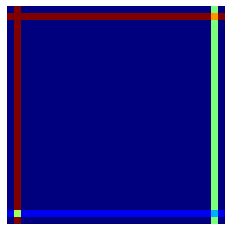

In [8]:
T = torch.zeros(1,1,32,32)
top, bottom, left, right = 100, 10, 100, 50
T[:,:,1,:] = top
T[:,:,-2,:] = bottom
T[:,:,:,1] = left
T[:,:,:,-2] = right
    
T[:,:,1,1] = (top + left) / 2
T[:,:,1,-2] = (top + right) / 2
T[:,:,-2,1] = (bottom + left) / 2
T[:,:,-2,-2] = (bottom + right) / 2
ax = plt.subplot()
T = T / 100
ax.imshow(T.detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.jet)
ax.axis('off')

In [9]:
sol = get_solution(T,[True, False, False, False])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [10]:
sol.size()

torch.Size([1, 1, 32, 32])

In [11]:
sol

tensor([[[[0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.7500, 1.0000],
          [0.0000, 0.9681, 0.9681,  ..., 0.7489, 0.5000, 0.0000],
          ...,
          [0.0000, 0.1307, 0.1307,  ..., 0.3012, 0.5000, 0.0000],
          [0.1000, 0.5500, 0.1000,  ..., 0.1000, 0.3000, 0.1000],
          [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000]]]],
       device='cuda:0')

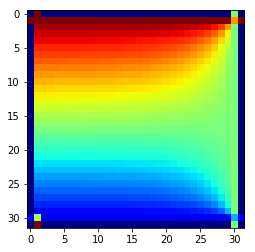

In [12]:
plt.imshow(sol.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.jet)

def rmsetomae(rmse, N):
    mae = np.sqrt(rmse**2*N)/N
    return mae

rmsetomae(9.3, 64*64)

loss for initial state is: tensor(0.5140, device='cuda:0')
[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
tensor([[[[1.0000, 1.0000, 1.0000],
          [0.0200, 0.9665, 0.9670],
          [0.0200, 0.9337, 0.9342],
          [0.0200, 0.9011, 0.9016],
          [0.0200, 0.8687, 0.8692],
          [0.0200, 0.8364, 0.8370],
          [0.0200, 0.8044, 0.8049],
          [0.0200, 0.7724, 0.7730],
          [0.0200, 0.7407, 0.7412],
          [0.0200, 0.7091, 0.7096],
          [0.0200, 0.6776, 0.6782],
          [0.0200, 0.6463, 0.6469],
          [0.0200, 0.6151, 0.6157],
          [0.0200, 0.5841, 0.5847],
          [0.0200, 0.5532, 0.5538],
          [0.0200, 0.5224, 0.5230],
          [0.0200, 0.4917, 0.4923],
          [0.0200, 0.4611, 0.4617],
          [0.0200, 0.4306, 0.4312],
          [0.0200, 0.4001, 0.4007],
          [0.0200, 0.3697, 0.3703],
          [0.0200, 0.3394, 0.3400],
      

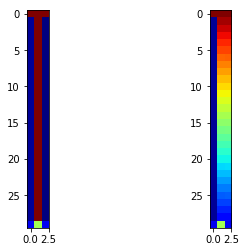

In [70]:
# CHECK LOSS for TRUE SOLUTION
T = torch.zeros(1,1,32,32)
top, bottom, left, right = 100, 10, 100, 50
nbc_left, nbc_upper, nbc_right, nbc_bottom = 2,0,0,0
T[:,:,1,:] = top
T[:,:,-2,:] = bottom
T[:,:,:,1] = left
T[:,:,:,-2] = right
    
T[:,:,1,1] = (top + left) / 2
T[:,:,1,-2] = (top + right) / 2
T[:,:,-2,1] = (bottom + left) / 2
T[:,:,-2,-2] = (bottom + right) / 2


T[:,:,2:-2,0] = nbc_left
T[:,:,0,2:-2] = nbc_upper
T[:,:,2:-2,-1] = nbc_right
T[:,:,-1,2:-2] = nbc_bottom
T = T / 100

bd = T[:,:,1:-1,0:3].type(dtype)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(bd.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.jet)

bdkernel =  torch.tensor([[[[0, 1/4, 0], [-1/2, -1, 1/2], [0, 1/4, 0]]]]).type(dtype)
print('loss for initial state is:', F.conv2d(bd, bdkernel).abs().mean())


sol = get_solution(T,[True, False, False, False])
# pad = nn.ConstantPad2d(1,2)
# padsol = pad(sol)
bdsol = sol[:,:,1:-1,0:3].type(dtype)
print(bdsol)

ax2.imshow(bdsol.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.jet)
print('loss for solution is:', F.conv2d(bdsol, bdkernel).abs().mean())
# plt.savefig('showBD2.png')
# plt.close()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
UNetv2(
  (encoding_layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_BN): ModuleList(
    (0): Bat

Text(0.5,1,'solution')

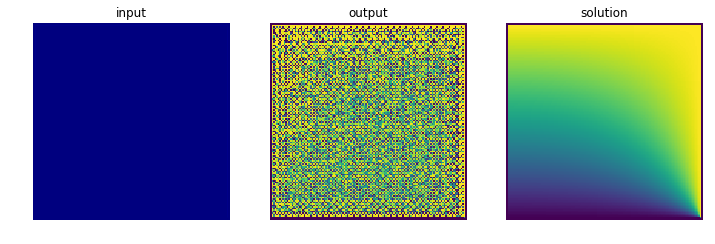

In [29]:
# TEST LEARNING
T = torch.zeros(1,1,128,128)
top, bottom, left, right = 100, 0, 0, 100
nbc_left, nbc_upper, nbc_right, nbc_bottom = 0,0,0,0
T[:,:,1,1:-1] = top
T[:,:,-2,1:-1] = bottom
T[:,:,1:-1,1] = torch.linspace(top, bottom, 126)
T[:,:,1:-1,-2] = right
    
T[:,:,1,1] = top
T[:,:,1,-2] = (top + right) / 2
T[:,:,-2,1] = bottom
T[:,:,-2,-2] = (bottom + right) / 2


T[:,:,2:-2,0] = nbc_left
T[:,:,0,2:-2] = nbc_upper
T[:,:,2:-2,-1] = nbc_right
T[:,:,-1,2:-2] = nbc_bottom
T = T/ 100
sol = get_solution(T,[True, False, False, False])


f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,12))
ax1.imshow(T.detach().numpy()[0,0,:,:], vmin=0, vmax=100, cmap=plt.cm.jet)
ax1.axis('off')
ax1.set_title('input')

unet = UNetv2(dtype = dtype, img_size = 128).type(dtype)
print(unet)
img = T.type(dtype) # prediction
isNeum=[True, False, False, False]
output = unet(img, isNeum)

# output = output * 100

print(img)
print(output)

ax2.imshow(output.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.viridis)
ax2.axis('off')
ax2.set_title('output')

ax3.imshow(sol.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.viridis)
ax3.axis('off')
ax3.set_title('solution')
# plt.savefig('testLearning.png')
# plt.close()

In [14]:
T

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
          [0.0000, 0.9655, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
          ...,
          [0.0000, 0.0345, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

In [16]:
rsol = sol[0,0,1:-1, 1:-1]
print(rsol[:,0])
# print(torch.linspace(100,0,30))

tensor([1.0000, 0.9712, 0.9424, 0.9134, 0.8843, 0.8549, 0.8253, 0.7953, 0.7649,
        0.7341, 0.7028, 0.6709, 0.6386, 0.6056, 0.5720, 0.5378, 0.5029, 0.4674,
        0.4312, 0.3944, 0.3570, 0.3190, 0.2804, 0.2414, 0.2019, 0.1620, 0.1218,
        0.0813, 0.0407, 0.0000], device='cuda:0')


In [9]:
def conv_loss(domain_size=32):
    "convolutional loss function based on steady heat equation"
    "Neumann condition version"
    h = L / (domain_size-3)
    kernel = torch.tensor([[[[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]]]]).type(dtype)
    bd_kernel = torch.tensor([[[[0, 1/4, 0], [-1/2*h, -1, 1/2], [0, 1/4, 0]]]]).type(dtype)
    
    full_size = domain_size 
    img_size = full_size
    reductions = []
    lambd = 128.0
    while img_size > 32:
        img_size /= 4
        indices = np.round(np.linspace(1, full_size-2, img_size)).astype(np.int32)
        indices = np.insert(indices, 0, 0)
        indices = np.append(indices, full_size - 1)
        reductions.append(np.ix_(indices, indices))
    def loss(input_img, isNeum):
        img = input_img[:,:,1:-1,1:-1]
        total_loss = F.conv2d(img, kernel).abs().mean() # main loss from original img
        if isNeum[0]:
            bd = input_img[:,:,1:-1,0:3] # the left boundary region that affect the boundary values on left
            total_loss += lambd * F.conv2d(bd, bd_kernel).abs().mean() # total loss = internel loss+bonudary loss
            for rows, cols in reductions:
                reduced_img = input_img[:,:,rows,cols] # include NMBC
                bd = reduced_img[:,:,1:-1,0:3]
#                 total_loss += F.conv2d(bd, bd_kernel).abs().mean()
        for rows, cols in reductions:
            reduced_img = input_img[:,:,rows,cols]
            total_loss += F.conv2d(reduced_img[:,:,1:-1,1:-1], kernel).abs().mean()
        return total_loss
    return loss

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(256, 256)
boudary loss is  tensor(3.1795e-05, device='cuda:0')
internal loss is  tensor(3.1997e-05, device='cuda:0')
boudary loss is  tensor(0.0003, device='cuda:0')
internal loss is  tensor(0.0004, device='cuda:0')
Loss function o

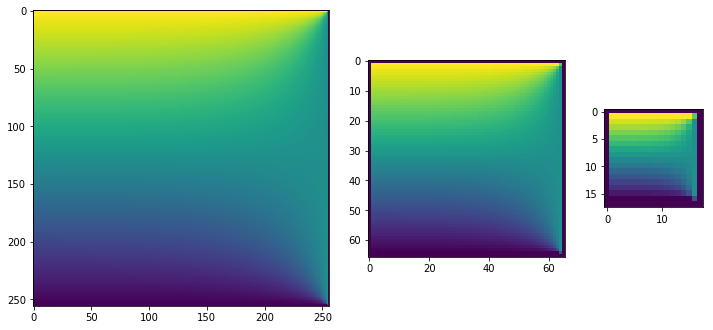

In [40]:
# TEST Coarse Grain regularization
testloss = conv_loss(256)
sample, solution = get_samples(256, 0, 1, 0.5, 0, isNeum=[True, False, False, False])
Tsol = torch.from_numpy(solution).unsqueeze(0).unsqueeze(0).type(dtype)
fig, ax = plt.subplots(1, 3, figsize = (12, 6), gridspec_kw={'width_ratios': [3, 2, 1]})
h = L / 256
kernel = torch.tensor([[[[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]]]]).type(dtype)
bd_kernel = torch.tensor([[[[0, 1/4, 0], [-1/2*h, -1, 1/2], [0, 1/4, 0]]]]).type(dtype)

ax[0].imshow(solution,vmin=0, vmax=1, cmap=plt.cm.viridis)
reductions = []
print(solution.shape)
full_size = 256
img_size = full_size

# indices = [0]
while img_size > 32:
    img_size /= 4
    indices = np.round(np.linspace(1, full_size-2, img_size)).astype(np.int32)
    indices = np.insert(indices, 0, 0)
    indices = np.append(indices, full_size - 1)
#     print(indices)
    reductions.append(np.ix_(indices, indices))
# print(rows, cols)
# print(indices)
ind = 1
for rows, cols in reductions:
    reduced_img = torch.from_numpy(solution).unsqueeze(0).unsqueeze(0)[:,:,rows,cols].type(dtype)
    ax[ind].imshow(reduced_img.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.viridis)
#     print(reduced_img[0,0,:,:])
#     ax[ind].axis('equal')
#     ax[ind].axis('off')
#     ax2.set_title('output')
    bd = reduced_img[:,:,1:-1,0:3]
#     plt.imshow(bd[0,0,:,:])
    print("boudary loss is ", F.conv2d(bd, bd_kernel).abs().mean())
    ind += 1
    print("internal loss is ", F.conv2d(reduced_img[:,:,1:-1,1:-1], kernel).abs().mean())
kernel = torch.tensor([[[[0, 1/4, 0], [1/4, -1, 1/4], [0, 1/4, 0]]]]).type(dtype)
# print(F.conv2d(reduced_img, kernel).abs().mean())
# print(Tsol[0,0,1:-1,1:-1])    
isNeum=[True, False, False, False]
loss = testloss(Tsol, isNeum)
loss_ini = testloss(sample.type(dtype), isNeum)
print("Loss function of the solution is :", loss)
print("Loss function of the sample is :", loss_ini)
# fig.savefig('showDownSampling.png')
del loss, loss_ini

In [17]:
def get_samples(size,left,top,right,bottom,nbc=[0,0,0,0],isNeum=[True, False, False, False]):
    
    T = torch.zeros(1,1,size,size)
    T[:,:,1,1:-1] = top
    T[:,:,-2,1:-1] = bottom
    T[:,:,1:-1,1] = left
    T[:,:,1:-1,-2] = right

    T[:,:,1,1] = (top + left) / 2
    T[:,:,1,-2] = (top + right) / 2
    T[:,:,-2,1] = (bottom + left) / 2
    T[:,:,-2,-2] = (bottom + right) / 2


    T[:,:,2:-2,0] = nbc[0]
    T[:,:,0,2:-2] = nbc[1]
    T[:,:,2:-2,-1] = nbc[2]
    T[:,:,-1,2:-2] = nbc[3]
    
    if isNeum[0]:
        T[:,:,1:-1,1] = torch.linspace(top,bottom,steps=size-2)
#         T[:,:,1,1] = (top + left) / 2
#         T[:,:,-2,1] = (bottom + left) / 2

    solution = get_solution(T, isNeum).cpu().detach().numpy()[0,0,:,:] # solution in 2D, while T in 4D
    return T, solution

In [11]:
def get_training_data(batch_size, domain_size, isNeum):
    "Get weakly supervised learning data"
    T = torch.zeros(batch_size,1,domain_size,domain_size)
    top = np.random.uniform(0.02,0.98)
    right = np.random.uniform(0.02,0.98)
    bottom = np.random.uniform(0.02,0.98)
    left = np.random.uniform(0.02,0.98)
    T[:,:,1,1:-1] = top
    T[:,:,-2,1:-1] = bottom
    T[:,:,1:-1,1] = left
    T[:,:,1:-1,-2] = right
    T[:,:,1:-1,0] = np.random.uniform(-0.005,0.005)
    if isNeum[0]:
        T[:,:,1:-1,1] = torch.linspace(top, bottom, steps = domain_size-2)
    return T



In [11]:
def show_samples(solution, prediction4D, epoch, dirName):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
    prediction = prediction4D.cpu().detach().numpy()[0,0,:,:]
    L1_distance = np.abs(prediction - solution)
 
    ax1.imshow(prediction, vmin=0, vmax=1, cmap=plt.cm.inferno)
    ax1.set_title("Generation")
    
    ax2.imshow(solution, vmin=0, vmax=1, cmap=plt.cm.inferno)
    ax2.set_title("FDM Solution")
    
    IM = ax3.imshow(L1_distance, vmin=0, vmax=1, cmap=plt.cm.inferno)
    ax3.set_title("L1 distance")
    
    cb_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
    cbar = fig.colorbar(IM, cax=cb_ax, orientation = "horizontal")
    fig.savefig('{}/predict_epoch{}.png'.format(dirName, epoch))
    plt.close()

In [161]:
# domain_size = 128
# sample, solution = get_samples(domain_size, 0, 0.8, 0.5, 0.2)
# prediction4D  = unet(sample.type(dtype),isNeum)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
# prediction = prediction4D.cpu().detach().numpy()[0,0,:,:]
# L1_distance = np.abs(prediction - solution)

# ax1.imshow(prediction, vmin=0, vmax=1, cmap=plt.cm.inferno)
# ax1.set_title("Generation")

# ax2.imshow(solution, vmin=0, vmax=1, cmap=plt.cm.inferno)
# ax2.set_title("FDM Solution")

# IM = ax3.imshow(L1_distance, vmin=0, vmax=1, cmap=plt.cm.inferno)
# ax3.set_title("L1 distance")

# cb_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
# cbar = fig.colorbar(IM, cax=cb_ax, orientation = "horizontal")



# prediction  = unet(sample.type(dtype),isNeum)
# dirName = '0924'
# plt.figure(figsize=(16, 10))

# plt.subplot(1,2,1)
# plt.imshow(sample.cpu().detach().numpy()[0,0,1:-1,0:3], cmap=plt.cm.viridis)
# plt.axis('equal')

# plt.subplot(1,2,2)
# plt.imshow(solution, vmin=0, vmax=100, cmap=plt.cm.viridis)
# plt.axis('equal')

# plt.savefig('{}/predict_epoch{}.png'.format(dirName, epoch))
# plt.close()

In [9]:
sample, solution = get_samples(domain_size, 0, 0.9, 0.5, 0.1)
get_loss = conv_loss()
print(sample)

loss = get_loss(torch.from_numpy(solution).unsqueeze(0).unsqueeze(0).type(dtype), isNeum)
loss

NameError: name 'get_samples' is not defined

In [ ]:
dtype = torch.cuda.FloatTensor
domain_size, batch_size = 128, 1

# T = torch.zeros(batch_size,1,domain_size,domain_size)
unet = UNetv2(dtype = dtype, img_size = domain_size).type(dtype)
optimizer = optim.Adam(unet.parameters(), lr = 2e-4)

# unet.load_state_dict(torch.load('1002_test2/history_2300.pth'))
# unet.eval()
# checkpoint = torch.load('1002_test2/histModel_5000.pth')
# unet.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# loss = checkpoint['loss']
# unet.eval()

# Initialize a U-net
# unet = UNet(dtype = dtype, img_size = domain_size).type(dtype) # initialize the UNET model

# create a new closure of conv_loss object
get_loss = conv_loss(domain_size)
# Specify optimizer
# Mark experiment
dirName = "1008"
iteration_number, epochs = 200, 3000
start_epoch = 1

# Getting samples and corresponding solutions
sample, solution = get_samples(domain_size, 0, 0.9, 0.5, 0.1) # NBC and ISNEUM by default

# Create directory for this exp.
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
loss_history = []        
# err_list = []
# start training
isNeum = [True, False, False, False]
for epoch in range(start_epoch, epochs + 1):
    # an epoch starts    
    epoch_loss = 0
    for k in range(iteration_number):
        T = get_training_data(batch_size, domain_size, isNeum)
#         inputT = T / 100 # input (0,1) values
        img = T.requires_grad_(True).type(dtype)
        output = unet(img) # output (0,1) values
        loss = get_loss(output, isNeum)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.data
        del loss, T
        
    # Conv loss tracking    
    epoch_loss = epoch_loss / iteration_number
    loss_history.append(float(epoch_loss))
    
    print('epoch{}/{}, loss = {:.6f}'.format(epoch, epochs, epoch_loss))
    
    prediction = unet(sample.type(dtype), isNeum) # convert back to 0~100
    show_samples(solution, prediction, epoch, dirName)
    
    # RMSE error
#     sol = torch.from_numpy(solution)
#     error = RMSELoss(unet(sample.type(dtype)), sol)
#     err_list.append(error)
    
    if epoch % 100 == 0:
#         torch.save(unet.state_dict(), '{}/history_{}.pth'.format(dirName, epoch))
#         print("Prediction on sample with RMSE = {:.3f}".format(error))
        torch.save({
            'epoch': epoch,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, '{}/histModel_{}.pth'.format(dirName, epoch))
    del epoch_loss
torch.save(unet.state_dict(), '{}/trainingLaplaceHist_{}.pth'.format(dirName, epoch))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Directory  1008  already exists
epoch1/3000, loss = 22.762142
epoch2/3000, loss = 3.471656
epoch3/3000, loss = 1.560614
epoch4/3000, loss = 1.128343
epoch5/3000, loss = 1.037424
epoch6/3000, loss = 0.967984
epoch7/3000, loss = 0.815690
epoch8/3000, loss = 0.754911
epoch9/3000, loss = 0.569839
epoch10/3000, loss = 0.607997
epoch11/3000, loss = 0.535601
epoch12/3000, loss = 0.659555
epoch13/3000, loss = 0.806640
epoch14/3000, loss = 0.395022
epoch15/3000, loss = 0.637664
epoch16/3000, loss = 0.667723
epoch17/3000, loss = 0.520689
epoch18/3000, loss = 0.457204
epoch19/3000, loss = 0.432454
epoch20/3000, loss = 0.4253

epoch256/3000, loss = 0.105467
epoch257/3000, loss = 0.108066
epoch258/3000, loss = 0.103221
epoch259/3000, loss = 0.116116
epoch260/3000, loss = 0.100992
epoch261/3000, loss = 0.100272
epoch262/3000, loss = 0.145156
epoch263/3000, loss = 0.092320
epoch264/3000, loss = 0.092239
epoch265/3000, loss = 0.090635
epoch266/3000, loss = 0.089044
epoch267/3000, loss = 0.101912
epoch268/3000, loss = 0.115352
epoch269/3000, loss = 0.138503
epoch270/3000, loss = 0.126725
epoch271/3000, loss = 0.110444
epoch272/3000, loss = 0.119225
epoch273/3000, loss = 0.107487
epoch274/3000, loss = 0.095424
epoch275/3000, loss = 0.132254
epoch276/3000, loss = 0.100669
epoch277/3000, loss = 0.096035
epoch278/3000, loss = 0.115437
epoch279/3000, loss = 0.097571
epoch280/3000, loss = 0.084739
epoch281/3000, loss = 0.114685
epoch282/3000, loss = 0.081821
epoch283/3000, loss = 0.100090
epoch284/3000, loss = 0.105936
epoch285/3000, loss = 0.094024
epoch286/3000, loss = 0.123455
epoch287/3000, loss = 0.096580
epoch288

epoch521/3000, loss = 0.078764
epoch522/3000, loss = 0.081887
epoch523/3000, loss = 0.080894
epoch524/3000, loss = 0.110216
epoch525/3000, loss = 0.093052
epoch526/3000, loss = 0.095554
epoch527/3000, loss = 0.065014
epoch528/3000, loss = 0.088273
epoch529/3000, loss = 0.096505
epoch530/3000, loss = 0.082437
epoch531/3000, loss = 0.092910
epoch532/3000, loss = 0.077920
epoch533/3000, loss = 0.096027
epoch534/3000, loss = 0.088999
epoch535/3000, loss = 0.078687
epoch536/3000, loss = 0.071073
epoch537/3000, loss = 0.070246
epoch538/3000, loss = 0.088445
epoch539/3000, loss = 0.099391
epoch540/3000, loss = 0.071569
epoch541/3000, loss = 0.079093
epoch542/3000, loss = 0.089324
epoch543/3000, loss = 0.084526
epoch544/3000, loss = 0.078181
epoch545/3000, loss = 0.065525
epoch546/3000, loss = 0.082964
epoch547/3000, loss = 0.083738
epoch548/3000, loss = 0.068442
epoch549/3000, loss = 0.084704
epoch550/3000, loss = 0.064045
epoch551/3000, loss = 0.075737
epoch552/3000, loss = 0.078833
epoch553

epoch786/3000, loss = 0.068483
epoch787/3000, loss = 0.083755
epoch788/3000, loss = 0.071548
epoch789/3000, loss = 0.060358
epoch790/3000, loss = 0.119351
epoch791/3000, loss = 0.060603
epoch792/3000, loss = 0.066117
epoch793/3000, loss = 0.063439
epoch794/3000, loss = 0.067296
epoch795/3000, loss = 0.058003
epoch796/3000, loss = 0.066326
epoch797/3000, loss = 0.057728
epoch798/3000, loss = 0.081180
epoch799/3000, loss = 0.068590
epoch800/3000, loss = 0.070993
epoch801/3000, loss = 0.079845
epoch802/3000, loss = 0.069640
epoch803/3000, loss = 0.068050
epoch804/3000, loss = 0.081659
epoch805/3000, loss = 0.064052
epoch806/3000, loss = 0.073490
epoch807/3000, loss = 0.061217
epoch808/3000, loss = 0.064562
epoch809/3000, loss = 0.089536
epoch810/3000, loss = 0.071764
epoch811/3000, loss = 0.076667
epoch812/3000, loss = 0.069918
epoch813/3000, loss = 0.073725
epoch814/3000, loss = 0.069245
epoch815/3000, loss = 0.068833
epoch816/3000, loss = 0.067376
epoch817/3000, loss = 0.069603
epoch818

epoch1049/3000, loss = 0.070874
epoch1050/3000, loss = 0.058314
epoch1051/3000, loss = 0.057561
epoch1052/3000, loss = 0.091738
epoch1053/3000, loss = 0.063219
epoch1054/3000, loss = 0.065208
epoch1055/3000, loss = 0.090300
epoch1056/3000, loss = 0.062411
epoch1057/3000, loss = 0.072859
epoch1058/3000, loss = 0.051133
epoch1059/3000, loss = 0.061246
epoch1060/3000, loss = 0.064325
epoch1061/3000, loss = 0.058488
epoch1062/3000, loss = 0.078797
epoch1063/3000, loss = 0.058401
epoch1064/3000, loss = 0.081176
epoch1065/3000, loss = 0.078229
epoch1066/3000, loss = 0.048494
epoch1067/3000, loss = 0.064439
epoch1068/3000, loss = 0.054296
epoch1069/3000, loss = 0.066482
epoch1070/3000, loss = 0.074722
epoch1071/3000, loss = 0.061642
epoch1072/3000, loss = 0.075602
epoch1073/3000, loss = 0.075161
epoch1074/3000, loss = 0.053234
epoch1075/3000, loss = 0.071324
epoch1076/3000, loss = 0.068463
epoch1077/3000, loss = 0.075326
epoch1078/3000, loss = 0.072233
epoch1079/3000, loss = 0.061531
epoch108

epoch1306/3000, loss = 0.070537
epoch1307/3000, loss = 0.050697
epoch1308/3000, loss = 0.048793
epoch1309/3000, loss = 0.057373
epoch1310/3000, loss = 0.059448
epoch1311/3000, loss = 0.077626
epoch1312/3000, loss = 0.075892
epoch1313/3000, loss = 0.059899
epoch1314/3000, loss = 0.058946
epoch1315/3000, loss = 0.070439
epoch1316/3000, loss = 0.056884
epoch1317/3000, loss = 0.066178
epoch1318/3000, loss = 0.061728
epoch1319/3000, loss = 0.053638
epoch1320/3000, loss = 0.067361
epoch1321/3000, loss = 0.061086
epoch1322/3000, loss = 0.060797
epoch1323/3000, loss = 0.050188
epoch1324/3000, loss = 0.053981
epoch1325/3000, loss = 0.066290
epoch1326/3000, loss = 0.061976
epoch1327/3000, loss = 0.064055
epoch1328/3000, loss = 0.063653
epoch1329/3000, loss = 0.049141
epoch1330/3000, loss = 0.054475
epoch1331/3000, loss = 0.065112
epoch1332/3000, loss = 0.065702
epoch1333/3000, loss = 0.074530
epoch1334/3000, loss = 0.055469
epoch1335/3000, loss = 0.058004
epoch1336/3000, loss = 0.078633
epoch133

epoch1563/3000, loss = 0.053764
epoch1564/3000, loss = 0.074485
epoch1565/3000, loss = 0.069034
epoch1566/3000, loss = 0.063155
epoch1567/3000, loss = 0.065157
epoch1568/3000, loss = 0.059714
epoch1569/3000, loss = 0.046674
epoch1570/3000, loss = 0.053617
epoch1571/3000, loss = 0.049863
epoch1572/3000, loss = 0.045310
epoch1573/3000, loss = 0.048934
epoch1574/3000, loss = 0.042434
epoch1575/3000, loss = 0.055564
epoch1576/3000, loss = 0.050472
epoch1577/3000, loss = 0.053201
epoch1578/3000, loss = 0.056019
epoch1579/3000, loss = 0.060799
epoch1580/3000, loss = 0.049122
epoch1581/3000, loss = 0.062909
epoch1582/3000, loss = 0.054847
epoch1583/3000, loss = 0.048537
epoch1584/3000, loss = 0.050757
epoch1585/3000, loss = 0.061203
epoch1586/3000, loss = 0.063543
epoch1587/3000, loss = 0.064687
epoch1588/3000, loss = 0.065919
epoch1589/3000, loss = 0.050340
epoch1590/3000, loss = 0.048706
epoch1591/3000, loss = 0.055931
epoch1592/3000, loss = 0.046823
epoch1593/3000, loss = 0.048022
epoch159

epoch1820/3000, loss = 0.058376
epoch1821/3000, loss = 0.053834
epoch1822/3000, loss = 0.050999
epoch1823/3000, loss = 0.066206
epoch1824/3000, loss = 0.059139
epoch1825/3000, loss = 0.065002
epoch1826/3000, loss = 0.040862
epoch1827/3000, loss = 0.056565
epoch1828/3000, loss = 0.048226
epoch1829/3000, loss = 0.049625
epoch1830/3000, loss = 0.054338
epoch1831/3000, loss = 0.056225
epoch1832/3000, loss = 0.073601
epoch1833/3000, loss = 0.047215
epoch1834/3000, loss = 0.054575
epoch1835/3000, loss = 0.047998
epoch1836/3000, loss = 0.056923
epoch1837/3000, loss = 0.058135
epoch1838/3000, loss = 0.045200
epoch1839/3000, loss = 0.068489
epoch1840/3000, loss = 0.039478
epoch1841/3000, loss = 0.050776
epoch1842/3000, loss = 0.046472
epoch1843/3000, loss = 0.061052
epoch1844/3000, loss = 0.052038
epoch1845/3000, loss = 0.054503
epoch1846/3000, loss = 0.054288
epoch1847/3000, loss = 0.067315
epoch1848/3000, loss = 0.043205
epoch1849/3000, loss = 0.052916
epoch1850/3000, loss = 0.045607
epoch185

epoch2077/3000, loss = 0.048217
epoch2078/3000, loss = 0.043006
epoch2079/3000, loss = 0.050522
epoch2080/3000, loss = 0.053028
epoch2081/3000, loss = 0.041550
epoch2082/3000, loss = 0.044198
epoch2083/3000, loss = 0.055807
epoch2084/3000, loss = 0.050348
epoch2085/3000, loss = 0.052160
epoch2086/3000, loss = 0.047583
epoch2087/3000, loss = 0.039682
epoch2088/3000, loss = 0.037824
epoch2089/3000, loss = 0.052484
epoch2090/3000, loss = 0.055435
epoch2091/3000, loss = 0.048369
epoch2092/3000, loss = 0.053359
epoch2093/3000, loss = 0.045469
epoch2094/3000, loss = 0.052160
epoch2095/3000, loss = 0.060612
epoch2096/3000, loss = 0.048311
epoch2097/3000, loss = 0.052568
epoch2098/3000, loss = 0.050707
epoch2099/3000, loss = 0.041721
epoch2100/3000, loss = 0.040796
epoch2101/3000, loss = 0.046755
epoch2102/3000, loss = 0.059888
epoch2103/3000, loss = 0.056977
epoch2104/3000, loss = 0.080074
epoch2105/3000, loss = 0.062774
epoch2106/3000, loss = 0.054263
epoch2107/3000, loss = 0.041901
epoch210

In [59]:
img = T.requires_grad_(True).type(dtype)
img

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-5.4304e-04,  8.7602e-01,  8.7602e-01,  ...,  8.7602e-01,
            3.3109e-01,  0.0000e+00],
          [-5.4304e-04,  8.6978e-01,  0.0000e+00,  ...,  0.0000e+00,
            3.3109e-01,  0.0000e+00],
          ...,
          [-5.4304e-04,  1.0155e-01,  0.0000e+00,  ...,  0.0000e+00,
            3.3109e-01,  0.0000e+00],
          [-5.4304e-04,  9.5301e-02,  9.5301e-02,  ...,  9.5301e-02,
            3.3109e-01,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0',
       grad_fn=<CopyBackwards>)

In [124]:
sample2, sol2 = get_samples(size, 0, 0.9, 0.5, 0.1)
prediction = unet(sample2.type(dtype), isNeum)
err = np.abs(sol2 - prediction.detach().cpu().numpy()[0,0,:,:])
err = torch.from_numpy(err[:,0:3]).unsqueeze(0).unsqueeze(0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


# See what happened on the prediction of left boundary

In [19]:

size = 128
sample2, sol2 = get_samples(size, 0, 0.9, 0.5, 0.1)


unet = UNet(dtype = dtype, img_size = size).type(dtype)
checkpoint = torch.load('1002_test2/history_2300.pth')
unet.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(unet.parameters(), lr = 2e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
unet.eval()
isNeum = [True, False, False, False]

prediction = unet(sample2.type(dtype), isNeum)
# bdkernel =  torch.tensor([[[[0, 1/4, 0], [-1/2*h, -1, 1/2], [0, 1/4, 0]]]]).type(dtype)
bd = prediction[:,:,1:-1,0:3]

err = np.abs(sol2 - prediction.detach().cpu().numpy()[0,0,:,:])
err = torch.from_numpy(err[:,0:3]).unsqueeze(0).unsqueeze(0)
# plt.imshow(bd.detach().cpu().numpy()[0,0,:,:], vmin = 0, vmax = 1)
# plt.axis("equal")
# F.conv2d(bd, bdkernel)
# print(bd.detach().cpu().numpy()[0,0,:,1])
# print(sol2[1:-1, 1])
# plt.plot(bd.detach().cpu().numpy()[0,0,:,2])
# plt.plot(sol2[1:-1,2],'--r')

plt.plot(bd.detach().cpu().numpy()[0,0,:,1])
plt.plot(sol2[1:-1,1])
# plt.savefig("leftBD2.png")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


FileNotFoundError: [Errno 2] No such file or directory: '1002_test2/history_2300.pth'

# Test for dirichlet BC with a distribution
Suppose the top BC is a linear distribution

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


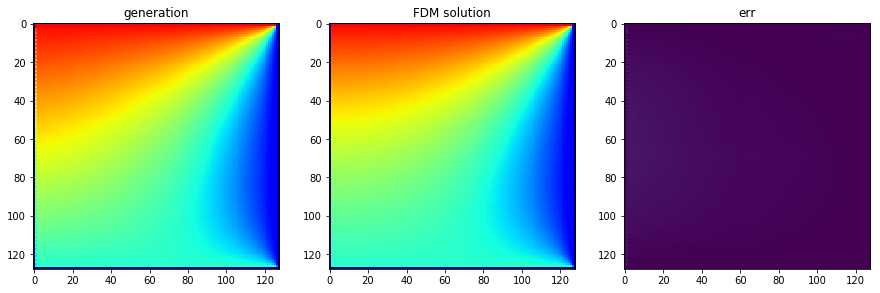

In [18]:
size = 128
TOP = 0.9
# top = torch.linspace(TOP,0.1,steps=size-2)
bottom = 0.4
right = 0.1
left = 0
T = torch.zeros(1,1,size,size)
T[:,:,1,1:-1] = TOP
T[:,:,-2,1:-1] = bottom
T[:,:,1:-1,1] = left
T[:,:,1:-1,-2] = right

T[:,:,1,1] = (TOP + left) / 2
T[:,:,1,-2] = (top[-1] + right) / 2
T[:,:,-2,1] = (bottom + left) / 2
T[:,:,-2,-2] = (bottom + right) / 2

if isNeum[0]:
    T[:,:,1:-1,1] = torch.linspace(TOP,bottom,steps=size-2)
time    
pred = unet(T.type(dtype), isNeum)
sol = get_solution(T, isNeum)
err = (sol - pred).abs()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 8))
ax1.imshow(pred.detach().cpu().numpy()[0,0,:,:],vmin=0,vmax=1,cmap=plt.cm.jet)
ax1.set_title("generation")
ax2.imshow(sol.detach().cpu().numpy()[0,0,:,:], vmin=0, vmax=1,cmap=plt.cm.jet)
ax2.set_title("FDM solution")

ax3.imshow(err.detach().cpu().numpy()[0,0,:,:], vmin=0, vmax=1.0)
ax3.set_title("err")

fig.savefig("results_new.png")

In [99]:
 np.random.uniform(0,1)

0.9473889650855442

In [44]:
from tqdm import tqdm_notebook as tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.01)

In [45]:
from ipywidgets import IntProgress
IntProgress(10,max=100)

IntProgress(value=10)

In [110]:
size = 128
sample2, sol2 = get_samples(size, 0, 80, 50, 10)
np.where(sol2<0)

# prediction = unet(sample.type(dtype),isNeum)
# plt.imshow(solution, vmin=-5, vmax=100, cmap=plt.cm.viridis)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


(array([], dtype=int64), array([], dtype=int64))

64


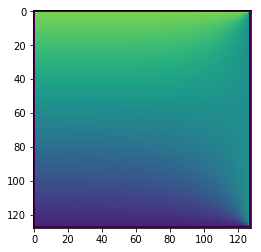

In [111]:
solution2 = sol2[1:-1, 1:-1]
print(size//2)
# print(size//2-2)
solution_center = sol2[(size//2), (size//2)]
solution_center
# [X,Y] = np.where(solution2 < 10)
plt.imshow(sol2, vmin=0, vmax=100, cmap=plt.cm.viridis)

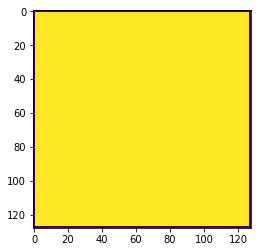

In [114]:
# unet = UNet(dtype = dtype, img_size = domain_size).type(dtype)
# unet.load_state_dict(torch.load('0926/history_6050.pth'))
# unet.eval()
T = unet(sample2.type(dtype),isNeum)
plt.imshow(T.detach().cpu().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.viridis)